# Adverserial Variational Optimization

*Gilles Louppe & Kayle Cranmer*

Notebook by Joeri Hermans

In [1]:
!date

Thu Oct 19 14:26:48 CEST 2017


Complex computer simulators are increasingly used across fields of science as generative models tying parameters of an underlying theory to experimental observations. Inference in this setup is often difficult, as simulators rarely admit a tractable density or likelihood function. We introduce Adversarial Variational Optimization (AVO), a likelihood-free inference algorithm for fitting a non-differentiable generative model incorporating ideas from empirical Bayes and variational inference. We adapt the training procedure of generative adversarial networks by replacing the differentiable generative network with a domain-specific simulator. We solve the resulting non-differentiable minimax problem by minimizing variational upper bounds of the two adversarial objectives. Effectively, the procedure results in learning a proposal distribution over simulator parameters, such that the corresponding marginal distribution of the generated data matches the observations. We present results of the method with simulators producing both discrete and continuous data.

**Manuscript**: [https://arxiv.org/abs/1707.07113](https://arxiv.org/abs/1707.07113)

## Configuration

### Imports

In [2]:
import numpy as np
import torch
import math
import matplotlib.mlab as mlab
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
import scipy.stats as stats
import scipy

from sklearn.utils import check_random_state

### Globals

In [3]:
seed = 1337
random_number_generator = check_random_state(seed)

batch_size = 512
num_features = 1 # cos(A)
num_epochs = 300
gp_lambda = 5.0

beam_energy = 45.0 # In GeV
fermi_constant = 0.9

theta_true = np.array([beam_energy, fermi_constant])

### Utility Methods

In [4]:
def plot_observations(X_observed, theta_optimal, normed=True):
    plt.grid(True)
    plt.hist(X_observed, histtype="bar", range=(-1, 1), bins=100, normed=normed)
    plt.xlim([-1, 1])
    if normed:
        plt.ylim([0, 2])
        plt.ylabel("Normalized Number of Events")
    else:
        plt.ylim([0, 3000])
        plt.ylabel("Number of Events")
    plt.title(r"Distribution of $\cos(A)$ in $e^-e^+ \rightarrow \mu^-\mu^+$ events." + "\n"
              r"$E_{beam}}$ = " + str(theta_optimal[0]) + "GeV   -   " + r"$G_f$ = " + str(theta_optimal[1]))
    plt.xlabel(r"$\cos(A)$")
    plt.show()
    
def random_gaussian(mu=[-1, 1], sigma=5.0):
    return {'mu': np.random.uniform(mu[0], mu[1]),
            'sigma': np.random.uniform(0.0, sigma)}

def draw_gaussian(d, num_samples, random_state=None):
    num_parameters = len(d['mu'])
    thetas = np.zeros((num_samples, num_parameters))
    mu = d['mu']
    sigma = d['sigma']
    for i in range(0, num_parameters):
        thetas[:, i] = stats.norm.rvs(size=num_samples,
                                      loc=mu[i], 
                                      scale=sigma[i],
                                      random_state=random_number_generator)
        
    return thetas

## Introduction

TODO Explain goals.

## Problem Statement

TODO

## Simulator

This notebook will only consider a simplified simulator from particle physics for electron-positron ($e^-e^+$) collisions resulting in muon-antipuon pairs ($\mu^-\mu^+$), i.e., $e^-e^+ \rightarrow \mu^-\mu^+$. The simulator approximates the distribution of observed measurements $\mathbf{x} = \cos(A) \in [-1, 1]$, where $A$ is the polar angle of the center of mass momenta of the outgoing muon with respect to the originally incoming electron. When we neglect the measurement uncertainty induced fromt he particle detectors, this random variable is approximately distributed as:

**Additional information**: [Positron - Electron Annihilation into Muon - Anti-muon](http://geant4.cern.ch/G4UsersDocuments/UsersGuides/PhysicsReferenceManual/html/node44.html)

In [5]:
def simulator(theta, n_samples, random_state=None):
    rng = check_random_state(random_state)
    samples = rej_sample_costheta(n_samples, theta, rng)

    return samples.reshape(-1, 1)

def rej_sample_costheta(n_samples, theta, rng):
    #sqrtshalf = theta[0] * (50 - 40) + 40
    #gf = theta[1] * (1.5 - 0.5) + 0.5
    sqrtshalf = theta[0]
    gf = theta[1]
    
    ntrials = 0
    samples = []
    x = np.linspace(-1, 1, num=1000)
    maxval = np.max(diffxsec(x, sqrtshalf, gf))

    while len(samples) < n_samples:
        ntrials = ntrials + 1
        xprop = rng.uniform(-1, 1)
        ycut = rng.rand()
        yprop = diffxsec(xprop, sqrtshalf, gf) / maxval
        if (yprop / maxval) < ycut:
            continue
        samples.append(xprop)

    return np.array(samples)

def diffxsec(costheta, sqrtshalf, gf):
    norm = 2. * (1. + 1. / 3.)
    return ((1 + costheta ** 2) + a_fb(sqrtshalf, gf) * costheta) / norm

def a_fb(sqrtshalf, gf):
    mz = 90
    gf_nom = 0.9
    sqrts = sqrtshalf * 2.
    a_fb_en = np.tanh((sqrts - mz) / mz * 10)
    a_fb_gf = gf / gf_nom

    return 2 * a_fb_en * a_fb_gf

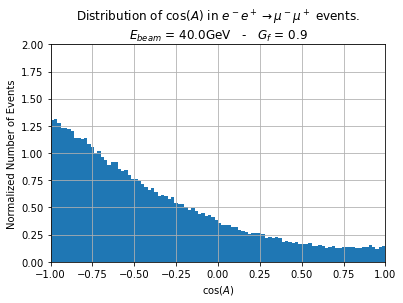

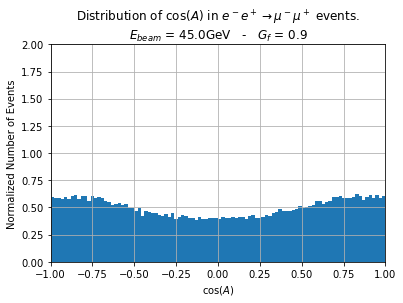

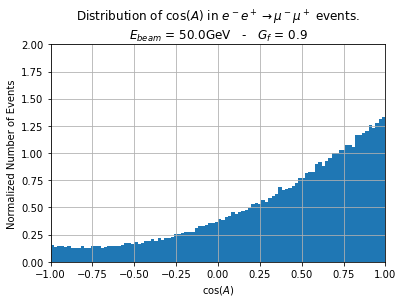

In [6]:
# Show the different distributions of cos(A) for different beam energies.
for energy in range(40, 51, 5):
    theta = np.array([energy, fermi_constant])
    X_observed = simulator(theta, 100000, random_state=random_number_generator)
    plot_observations(X_observed, theta)

## Model

In this section we describe the adverserial model we'll be training to fit the adverserial objective.

In [20]:
class Critic(torch.nn.Module):
    
    def __init__(self, num_features, num_hidden):
        super(Critic, self).__init__()
        self.fc_1 = torch.nn.Linear(num_features, num_hidden)
        self.fc_2 = torch.nn.Linear(num_hidden, num_hidden)
        self.fc_3 = torch.nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        
        return x

### Experimental Data

Before any inference can be done on our parameters of interest, i.e., the beam energy, $E_{beam}$, and Fermi's constant, $G_f$, some kind of experiment needs to sample from the computation of Nature, which is the distribution $p_r(x)$. However, in order to sample from this distribution, an experiment will have to be build, and data needs to be collected with this experiment.

To reduce the cost which is associated with building an experiment, and connecting it with this notebook, we simply run a simulator with the parameterization for which we now represent the "true" physical parameters, i.e.: $E_{beam} = 42$ GeV and $G_f = .9$.

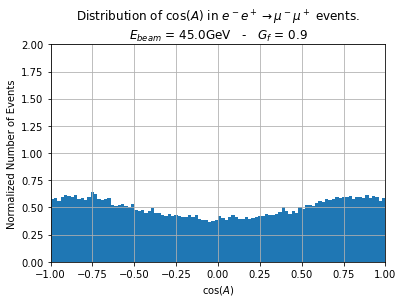

In [8]:
# Obtain the samples from the experiment.
p_r_x = simulator(theta_true, 100000, random_state=random_number_generator)

# Draw the distribution.
plot_observations(p_r_x, theta_true)

### Prior Initialization

In [9]:
# Initialize prior of p(theta | phi).
p_theta_phi = {'mu': [], 'sigma': []}

# Sample a random Gaussian for the beam energy.
g = random_gaussian(mu=[30, 60], sigma=1.0)
p_theta_phi['mu'].append(g['mu'])
p_theta_phi['sigma'].append(g['sigma'])

# Sample a random Gaussian for Fermi's paradox.
g = random_gaussian(mu=[0, 2], sigma=1.0)
p_theta_phi['mu'].append(g['mu'])
p_theta_phi['sigma'].append(g['sigma'])

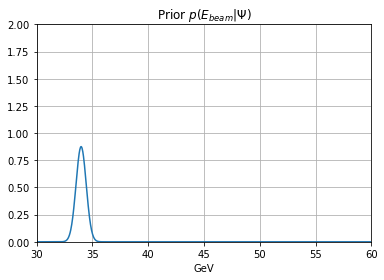

In [10]:
# Obtain the parameterization of the beam energy prior.
prior_beam_energy_mu = p_theta_phi['mu'][0]
prior_beam_energy_sigma = p_theta_phi['sigma'][0]
prior_beam_energy_variance = prior_beam_energy_sigma ** 2

# Draw the prior over the beam enery.
x = np.linspace(30, 60, 1000)
plt.plot(x, mlab.normpdf(x, prior_beam_energy_mu, prior_beam_energy_sigma))
plt.xlim([30, 60])
plt.ylim([0, 2])
plt.xlabel("GeV")
plt.grid(True)
plt.title(r"Prior $p(E_{beam}|\Psi)$")
plt.show()

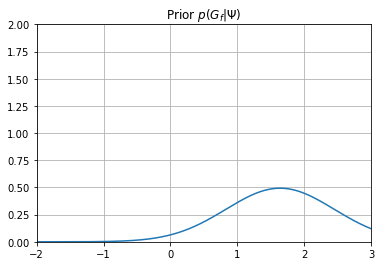

In [11]:
# Obtain the parameterization of Fermi's constant prior.
prior_gf_mu = p_theta_phi['mu'][1]
prior_gf_sigma = p_theta_phi['sigma'][1]
prior_gf_variance = prior_gf_sigma ** 2

# Draw the prior over the beam enery.
x = np.linspace(-2, 3, 1000)
plt.plot(x, mlab.normpdf(x, prior_gf_mu, prior_gf_sigma))
plt.xlim([-2, 3])
plt.ylim([0, 2])
plt.grid(True)
plt.title(r"Prior $p(G_f|\Psi)$")
plt.show()

### Sample $\theta$'s from prior

We only have to sample $\frac{1}{2}$ batch-size samples from the generator since the other half will be filled with fake examples.

In [12]:
thetas = draw_gaussian(p_theta_phi, batch_size // 2, random_state=random_number_generator)

Now we have sampled some thetas (both $E_{beam}$ and $G_f$ that have to be simulated in order to make a prediction, we can plot them to check if the match our prior over those parameters.

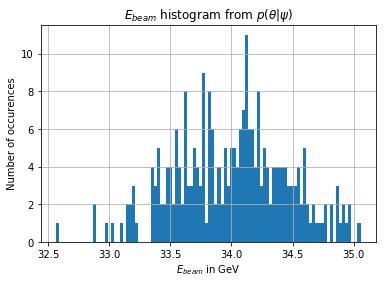

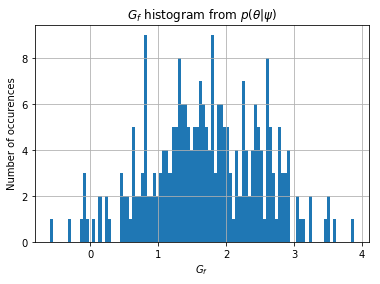

In [13]:
theta_beam_energy = thetas[:, 0]
theta_fermi_constant = thetas[:, 1]

# Plot the histogram of the sampled beam energy.
plt.title(r"$E_{beam}$ histogram from $p(\theta|\psi)$")
plt.hist(theta_beam_energy, bins=100)
plt.grid(True)
plt.xlabel(r"$E_{beam}$ in GeV")
plt.ylabel("Number of occurences")
plt.show()

# Plot the histogram of the sampled Fermi's constant.
plt.title(r"$G_f$ histogram from $p(\theta|\psi)$")
plt.hist(theta_fermi_constant, bins=100)
plt.grid(True)
plt.xlabel(r"$G_f$")
plt.ylabel("Number of occurences")
plt.show()

### Constructing training data

The authors use the sampled theta's to obtain a sample from the simulator under the specified configuration. This can be treated as an instance of "fake" information.

In [14]:
# Create input-vector of generated features under theta (E_beam and G_f).
_x_generated = np.zeros((batch_size // 2, num_features))

# Apply the simulator to generate the samples.
for i, theta in enumerate(thetas):
    sample = simulator(theta, 1, random_state=random_number_generator)
    _x_generated[i, :] = sample

Of course, adverserial training requires "true" samples as well. In the current approach, this is done be sampling from the *true* experimental information, i.e., observed data.

In [15]:
# Create input-vector of real features.
_x_real = np.zeros((batch_size // 2, num_features))
num_observations = len(p_r_x)

# Sample randomly from observed distribution.
for i in range(0, batch_size // 2):
    index = random_number_generator.randint(low=0, high=num_observations)
    sample = p_r_x[index]
    _x_real[i, :] = sample.ravel()

Vertically stack the generated and real vector to form a single training batch, and finally, construct an expected output vector to construct the loss of the critic.

In [16]:
# Construct the input vector.
x = np.vstack([_x_generated, _x_real])

# Construct the expected output of the critic.
y_expected = np.zeros((batch_size, 1))
# Set the real samples to 1.
y_expected[batch_size // 2:] = 1.0

### Forward pass of the critic

In [17]:
# Define the critic with the specified number of hidden neurons.
num_hidden = 20

# Allocate the Critic with the specified configuration.
critic = Critic(num_features, num_hidden)

In [18]:
# Convert the Numpy array to a PyTorch Variable
x = torch.autograd.Variable(torch.from_numpy(x).float(), requires_grad=False)
y_expected = torch.autograd.Variable(torch.from_numpy(y_expected).float(), requires_grad=False)

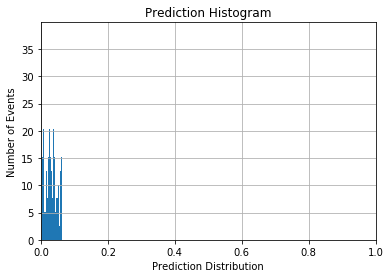

In [21]:
# Allocate the Critic with the specified configuration.
critic = Critic(num_features, num_hidden)

# Do the prediction.
y = critic(x)

# Plot the histogram of the prediction.
plt.hist(y.data.numpy(), bins=100, normed=True)
plt.grid(True)
plt.xlim([0, 1])
plt.xlabel(r"Prediction Distribution")
plt.ylabel("Number of Events")
plt.title("Prediction Histogram")
plt.show()

### Backward pass of the critic

To enable the optimization of the Critic, we need to define an optimizer. Of course, we could implement this by hand, but we can Simply use the Adam optimizer which is already provided by PyTorch.

In [22]:
_x_r = Variable(torch.from_numpy(_x_real).float(), requires_grad=True)
_x_g = Variable(torch.from_numpy(_x_generated).float(), requires_grad=True)

In [23]:
def compute_gradient_penalty(net, real, fake):
    epsilon = torch.rand(batch_size // 2, 1)
    _x_hat = epsilon * real + ((1. - epsilon) * fake)
    _x_hat = Variable(_x_hat, requires_grad=True)
    y_hat = net(_x_hat)
    
    gradients = torch.autograd.grad(outputs=y_hat, inputs=_x_hat, grad_outputs=torch.ones(y_hat.size()),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradient_penalty = 5.0 * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

In [24]:
import gc

gc.collect()

44434

In [25]:
optimizer = torch.optim.Adam(critic.parameters(), lr=0.0001)

Wasserstein: [-0.5442186]
Gradient Penalty: [ 0.0159796]
Loss: [-0.76387787]


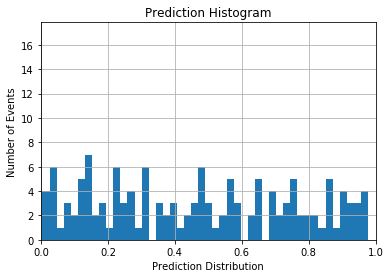

In [42]:
one = Variable(torch.FloatTensor([1]), requires_grad=True)
ones = Variable(torch.ones(batch_size // 2, 1), requires_grad=True)
zero = torch.FloatTensor([0])
mone = one * -1

for i in range(0, 1000):
    # Reset the gradients.
    critic.zero_grad()
    # Train with real.
    y_r = critic(_x_r).mean() + 1e-16
    y_r.backward(mone)
    # Train with fake.
    y_g = critic(_x_g).mean() + 1e-16
    y_g.backward(one)
    # Train with gradient penalty.
    gp = compute_gradient_penalty(critic, _x_r.data, _x_g.data) + 1e-16
    gp.backward()
    loss = y_g - y_r + gp
    optimizer.step()

gc.collect()
print("Wasserstein: " + str((y_g - y_r).mean().data.numpy()))
print("Gradient Penalty: " + str(gp.mean().data.numpy()))
print("Loss: " + str(loss.mean().data.numpy()))

# Do the prediction.
y = critic(x)

# Plot the histogram of the prediction.
plt.hist(y.data.numpy(), bins=100)
plt.grid(True)
plt.xlabel(r"Prediction Distribution")
plt.ylabel("Number of Events")
plt.title("Prediction Histogram")
plt.xlim([0, 1])
plt.show()

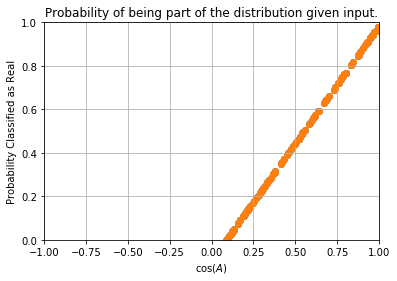

In [44]:
plt.scatter(x.data.numpy(), y.data.numpy())
plt.scatter(x.data.numpy(), y_old.data.numpy())
plt.xlabel(r"$\cos(A)$")
plt.ylabel("Probability Classified as Real")
plt.title("Probability of being part of the distribution given input.")
plt.xlim([-1, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.show()
y_old = y